# Batch Processing - in Memory

This notebook shows examples for batch power flow and time-domain calculations. Readers are supposed to have read the previous examples, especially Example 7 for parallel simulations.

In [1]:
import andes
import numpy as np

from matplotlib import pyplot as plt

## Batch Power Flow Calculation

Use the Kundur's system as the example. Suppose we want to calculate power flow for the same system structure but for different load levels.

In [2]:
kundur = andes.utils.get_case('kundur/kundur_full.xlsx')

In [3]:
ss = andes.run(kundur,
               no_output=True,
               default_config=True,
               verbose=30,  # set logging level to WARNING
               )

-> Single process finished in 0.4701 seconds.


There are two PQ loads in the Kundur's system with `idx`es of `PQ_0` and `PQ_1`.

In [4]:
ss.PQ.as_df(vin=True)

,idx,u,name,bus,Vn,p0,q0,vmax,vmin,owner
uid,,,,,,,,,,
0,PQ_0,1.0,PQ_0,7,230.0,11.59,-0.735,1.1,0.9,1
1,PQ_1,1.0,PQ_1,8,230.0,15.75,-0.899,1.1,0.9,1


If we have a range of active power for each load, such as 

In [5]:
n_samples = 3  # Note: increase `n_samples` for higher data resolution 

pq0_values = np.linspace(10, 12, n_samples)
pq1_values = np.linspace(12, 18, n_samples)

where there are 3 samples for `PQ_0.p0` between `[10, 12]` and 3 samples for `PQ_1.p0` between `(12, 18)`.

We can use a for loop to set the load values and calculate power flow for each point.

Suppose we want to retrieve the voltage magnitude for each case, we use `v_results` the voltage results. Results that are not saved will be discarded.

In [6]:
v_results = np.zeros((ss.Bus.n, n_samples ** 2))
idx = 0

for ii in pq0_values:
    ss.PQ.alter("p0", "PQ_0", ii)
    for jj in pq1_values:
        
        ss.PQ.alter("p0", "PQ_1", jj)

        ss.PFlow.run()
        v_results[:, idx] = ss.dae.y[ss.Bus.v.a]
        
        idx += 1

Let's plot the results.

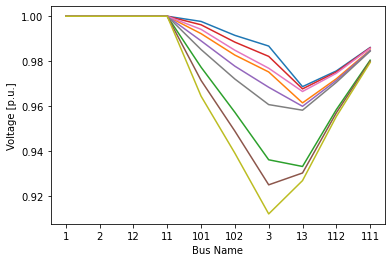

In [7]:
lines = plt.plot(v_results)

xl = plt.xlabel('Bus Name')
yl = plt.ylabel('Voltage [p.u.]')

tk = plt.xticks(np.arange(ss.Bus.n), ss.Bus.name.v)

One should be aware that the for-loop based approach is single-threaded. It does not take advantage of multi-core processors. 

If the total number of scenarios are huge, one should refer to Example 7 to save all scenarios to excel files and use multi-processing.

## Batch Time-Domain Simulation

The next example shows how to run batch time-domain simulations for different events.

Suppose we want to create one scenario for each line trip event, which is actuated through `Toggle`. For the same system, we want to add Toggles for each line, run the simulation, and save results.

In [8]:
kundur = andes.utils.get_case('kundur/kundur_full.xlsx')

We use `andes.load()` with `setup=False` to load the test case. 

**It is important to note that one must pass `setup=False` so that adding Toggles can be allowed.**

In [9]:
ss = andes.load(kundur, setup=False)

The `idx`es of all available lines to trip are in `ss.Line.idx.v`:

In [10]:
idxes = ss.Line.idx.v

In [11]:
ss.Toggle.as_df()

,idx,u,name,model,dev,t
uid,,,,,,
0,1,1,Toggle_1,Line,Line_8,2


We use `ss.add()` to add two Toggles for each line at 1 second and 1.1 seconds to simulate a line opening and closing. `ss.add()` takes a model name, "Toggle", as the positional argument, and a dictionary for the Toggle device parameters.

A note for this particular test case is that `kundur_full.xlsx` already comes with a `Toggle` with `idx==1`. To not to interfere with our scenarios, we need to disable it using `ss.Toggle.alter`.

After adding Toggle devices, we need to manually call `ss.setup()` to finish the data structure setup. Then, power flow and time-domain simulation can be performed. 

We store the results in a dictionary where keys are the line names and values are the systems. Code is as follows.

In [12]:
results = dict()

for idx in idxes:
    ss = andes.load(kundur, setup=False)
    
    ss.add('Toggle', dict(model="Line", dev=idx, t=1.0))
    ss.add('Toggle', dict(model="Line", dev=idx, t=1.1))
    
    ss.setup()                     # no `ss.add()` calls are allowed after setup()
    ss.Toggle.alter('u', 1, 0.0)  # disable the existing Toggle with idx=1 (this is for the particular case)

    ss.PFlow.run()
    ss.TDS.config.tf = 5       # simulate for 5 seconds to save time
    ss.TDS.config.no_tqdm = 1  # disable progres bar printing 
    ss.TDS.run()
    
    results[idx] = ss

<Toggle Toggle_2>: Line.Line_0 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_0 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_1 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_1 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_2 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_2 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_3 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_3 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_4 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_4 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_5 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_5 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_6 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_6 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_7 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.L

Time step reduced to zero. Convergence is not likely.
Simulation terminated at t=1.1001 s.


<Toggle Toggle_2>: Line.Line_11 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_11 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_12 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_12 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_13 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_13 status changed to 1 at t=1.1 sec.
<Toggle Toggle_2>: Line.Line_14 status changed to 0 at t=1.0 sec.
<Toggle Toggle_3>: Line.Line_14 status changed to 1 at t=1.1 sec.


Jacobian matrix is singular.
Suspect diagonal elements: [55, 61]
NaN found in solution. Convergence is not likely
Simulation terminated at t=1.5808 s.


Not all cases will solve due to system instability. For the converged cases, one can export the data or plot results following Example 1.

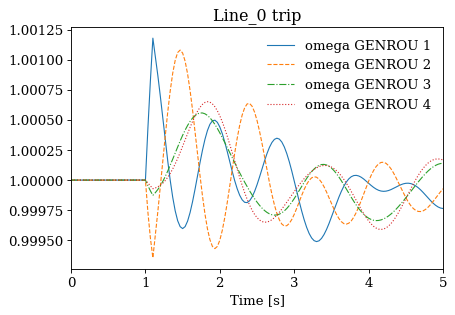

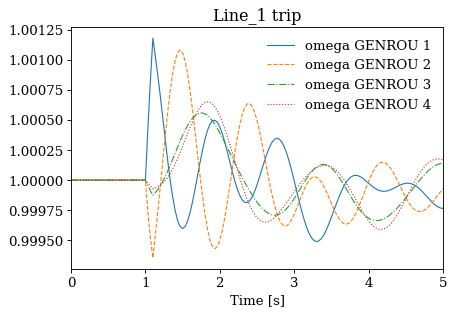

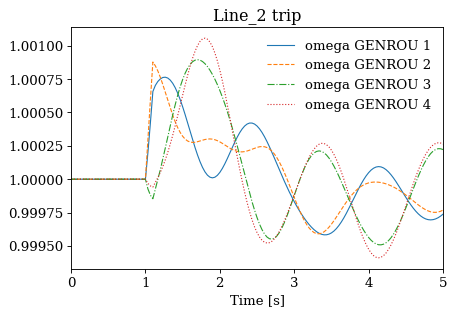

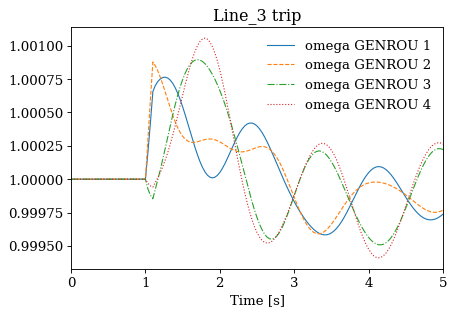

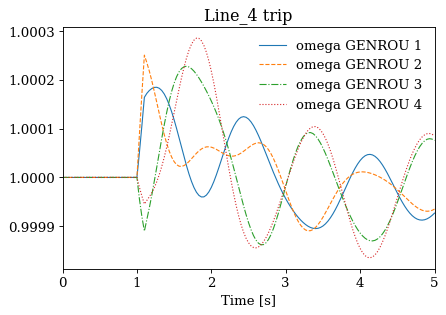

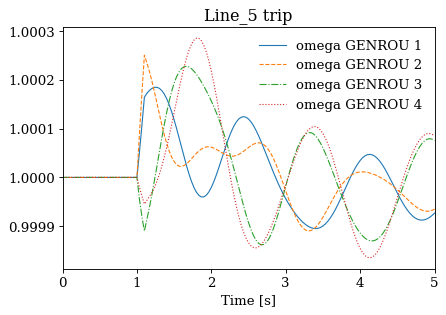

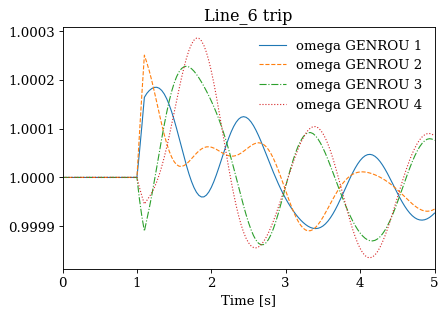

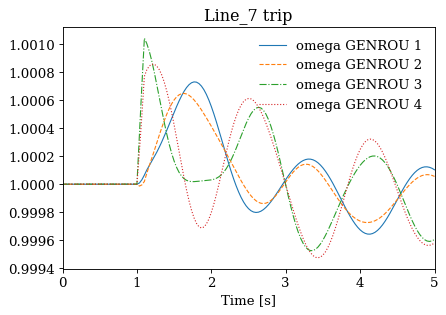

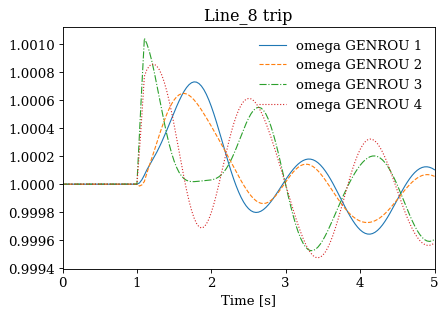

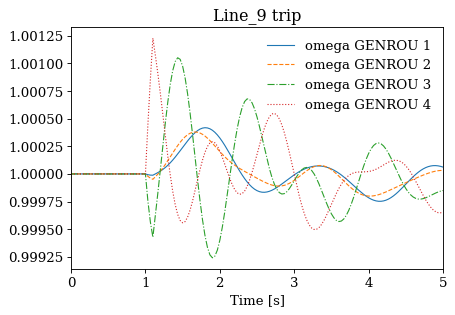

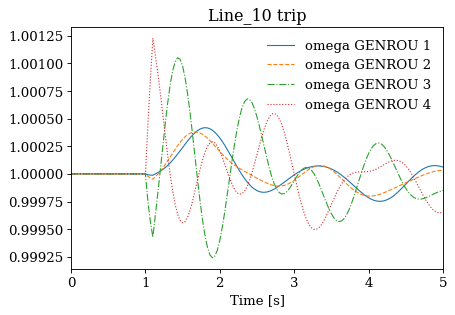

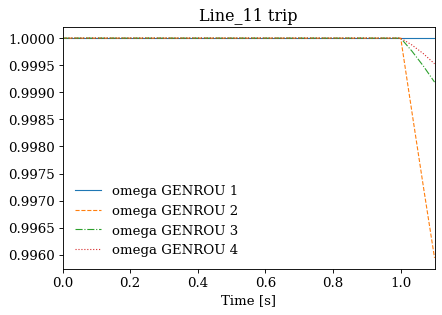

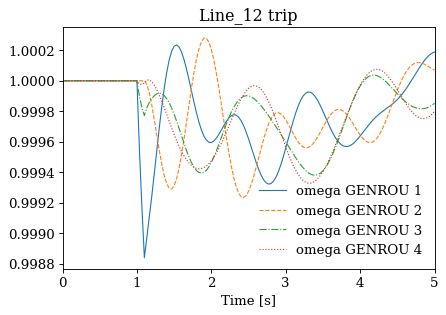

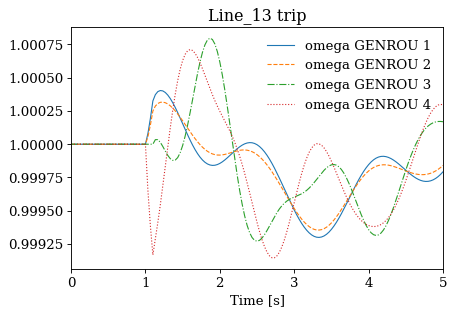

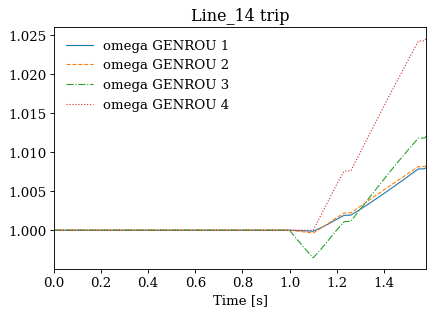

In [13]:
for idx, ss in results.items():
    ss.TDS.plt.plot(ss.GENROU.omega, title=f'{idx} trip', latex=False, dpi=80)

In [14]:
!rm -rf batch_cases/